## Extractive Text Summarization with Seq2Seq model  
Develop a basic character-level seq2seq model for text summarization. Use a word-level model, which is quite common in the domain of text processing. For this article, use character level models. As mentioned earlier, encoder and decoder architecture is a way of creating RNNs for sequence prediction. Encoders read the entire input sequence and encode it into an internal representation, usually, a fixed-length vector named the context vector. The decoder, on the other hand, reads the encoded input sequence from the encoder and produces the output sequence.

The encoder-decoder architecture consists of two primary models: one reads the input sequence and encodes it to a fixed-length vector, and the second decodes the fixed-length vector and outputs the predicted sequence. This architecture is designed for seq2seq problems.

the data source for this excercise is from [kaggle](https://www.kaggle.com/sunnysai12345/news-summary)

In [1]:
import pandas as pd
import re
from bs4 import BeautifulSoup


In [2]:
path = '/Users/ndah/NEC/aims_nlp/wine_review/'

#####--- TO run on all reviews remove nrows=2000 ---#####
summary = pd.read_csv(path + 'news_summary.csv', encoding='iso-8859-1', nrows=6000)
raw = pd.read_csv(path + 'news_summary_more.csv', encoding='iso-8859-1', nrows=6000)

In [3]:
pre1 = raw.iloc[:, 0:2].copy()
pre2 = summary.iloc[:, 0:6].copy()

# To increase the intake of possible text values to build a reliable model
pre2['text'] = pre2['author'].str.cat(pre2['date'].str.cat(pre2['read_more'].str.cat(pre2['text'].str.cat(pre2['ctext'], sep=' '), sep=' '), sep=' '), sep=' ')

pre = pd.DataFrame()
pre['text'] = pd.concat([pre1['text'], pre2['text']], ignore_index=True)
pre['summary'] = pd.concat([pre1['headlines'], pre2['headlines']], ignore_index=True)

In [4]:
pre.head()

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


### Cleaning the Data  
The data you procured can have non-alphabetic characters which you can remove before training the model. To do this, you can use the re (Regular Expressions) library

In [5]:
# Remove non-alphabetic characters (Data Cleaning)

def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    
    return stripped_text

def text_strip(column):
    """ Clean review data"""
    for row in column:

        row = re.sub("(\\t)", " ", str(row)).lower()
        row = re.sub("(\\r)", " ", str(row)).lower()
        row = re.sub("(\\n)", " ", str(row)).lower()
        
        # remove html tags
        row = strip_html_tags(row)
        
        # remove URL from text
        row = re.sub(r"http\S+", "", row)        
        
        # Remove _ if it occurs more than one time consecutively
        row = re.sub("(__+)", " ", str(row)).lower()

        # Remove - if it occurs more than one time consecutively
        row = re.sub("(--+)", " ", str(row)).lower()

        # Remove ~ if it occurs more than one time consecutively
        row = re.sub("(~~+)", " ", str(row)).lower()

        # Remove + if it occurs more than one time consecutively
        row = re.sub("(\+\++)", " ", str(row)).lower()

        # Remove . if it occurs more than one time consecutively
        row = re.sub("(\.\.+)", " ", str(row)).lower()

        # Remove the characters - <>()|&©ø"',;?~*!
        row = re.sub(r"[<>()|&©ø\[\]\'\",;?~*!]", " ", str(row)).lower()

        # Remove mailto:
        row = re.sub("(mailto:)", " ", str(row)).lower()

        # Remove \x9* in text
        row = re.sub(r"(\\x9\d)", " ", str(row)).lower()

        # Replace INC nums to INC_NUM
        row = re.sub("([iI][nN][cC]\d+)", "INC_NUM", str(row)).lower()

        # Replace CM# and CHG# to CM_NUM
        row = re.sub("([cC][mM]\d+)|([cC][hH][gG]\d+)", "CM_NUM", str(row)).lower()

        # Remove punctuations at the end of a word
        row = re.sub("(\.\s+)", " ", str(row)).lower()
        row = re.sub("(\-\s+)", " ", str(row)).lower()
        row = re.sub("(\:\s+)", " ", str(row)).lower()

        # Replace any url to only the domain name
        try:
            url = re.search(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", str(row))
            repl_url = url.group(3)
            row = re.sub(r"((https*:\/*)([^\/\s]+))(.[^\s]+)", repl_url, str(row))
        except:
            pass

        # Remove multiple spaces
        row = re.sub("(\s+)", " ", str(row)).lower()

        # Remove the single character hanging between any two spaces
        row = re.sub("(\s+.\s+)", " ", str(row)).lower()

        yield row

In [6]:
processed_text = text_strip(pre['text'])
processed_summary = text_strip(pre['summary'])

The _START_ and _END_ tokens denote the start and end of the summary, respectively. This will be used later to detect and remove empty summaries.

In [7]:
import spacy
from time import time

nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) 

# Process text as batches and yield Doc objects in order
text = [str(doc) for doc in nlp.pipe(processed_text, batch_size=500)]
summary = ['_START_ '+ str(doc) + ' _END_' for doc in nlp.pipe(processed_summary, batch_size=500)]

In [8]:
text[0]

'saurav kant an alumnus of upgrad and iiit-b pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad 360-degree career support helped him transition to data scientist at tech mahindra with 90% salary hike upgrad online power learning has powered lakh+ careers.'

In [9]:
summary[0]

'_START_ upgrad learner switches to career in ml al with 90% salary hike _END_'

#### Determining the Maximum Sequence Lengths  
Plot a graph to determine the frequency ranges tied to the lengths of text and summary, i.e., determine the range of length of words where the maximum number of texts and summaries fall into.  

From the graphs, you can determine the range where the maximum number of words fall into. For summary, you can assign the range to be 0-15.
To find the range of text which we aren't able to clearly decipher from the graph, consider a random range and find the percentage of words falling into that range.

In [10]:
pre['cleaned_text'] = pd.Series(text)
pre['cleaned_summary'] = pd.Series(summary)

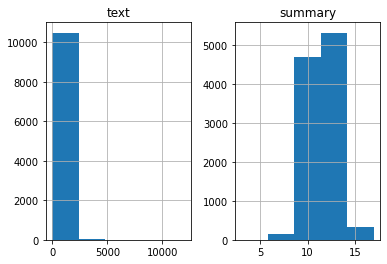

In [11]:
import matplotlib.pyplot as plt

text_count = []
summary_count = []

for sent in pre['cleaned_text']:
    text_count.append(len(sent.split()))
    
for sent in pre['cleaned_summary']:
    summary_count.append(len(sent.split()))

graph_df = pd.DataFrame() 

graph_df['text'] = text_count
graph_df['summary'] = summary_count

graph_df.hist(bins = 5)
plt.show()

In [12]:
# Check how much % of text have 0-100 words
cnt = 0
for i in pre['cleaned_text']:
    if len(i.split()) <= 500:
        cnt = cnt + 1
print(cnt / len(pre['cleaned_text']))

0.9150656267833365


In [13]:
# Model to summarize the text between 0-15 words for Summary and 0-100 words for Text
max_text_len = 500
max_summary_len = 15

In [14]:
# Select the Summaries and Text which fall below max length for both
import numpy as np

cleaned_text = np.array(pre['cleaned_text'])
cleaned_summary= np.array(pre['cleaned_summary'])

short_text = []
short_summary = []

for i in range(len(cleaned_text)):
    if len(cleaned_summary[i].split()) <= max_summary_len and len(cleaned_text[i].split()) <= max_text_len:
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre = pd.DataFrame({'text': short_text,'summary': short_summary})

In [15]:
post_pre.head()

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,_START_ upgrad learner switches to career in m...
1,kunal shah credit card bill payment platform c...,_START_ delhi techie wins free food from swigg...
2,new zealand defeated india by wickets in the f...,_START_ new zealand end rohit sharma-led india...
3,with aegon life iterm insurance plan customers...,_START_ aegon life iterm insurance plan helps ...
4,speaking about the sexual harassment allegatio...,_START_ have known hirani for yrs what if meto...


Now add start of the sequence (sostok) and end of the sequence (eostok) to denote start and end of the summaries, respectively. This shall be useful to trigger the start of summarization during the inferencing phase.

In [16]:
# Add sostok and eostok
post_pre['summary'] = post_pre['summary'].apply(lambda x: 'sostok ' + x + ' eostok')
post_pre.head()

,text,summary
0,saurav kant an alumnus of upgrad and iiit-b pg...,sostok _START_ upgrad learner switches to care...
1,kunal shah credit card bill payment platform c...,sostok _START_ delhi techie wins free food fro...
2,new zealand defeated india by wickets in the f...,sostok _START_ new zealand end rohit sharma-le...
3,with aegon life iterm insurance plan customers...,sostok _START_ aegon life iterm insurance plan...
4,speaking about the sexual harassment allegatio...,sostok _START_ have known hirani for yrs what ...


#### Tokenizing the Text
First split the data into train and test data chunks.

In [17]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(
    np.array(post_pre["text"]),
    np.array(post_pre["summary"]),
    test_size=0.1,
    random_state=0,
    shuffle=True,
)

In [18]:
# Tokenize the text to get the vocab count 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_train))

In [19]:
# Find the percentage of occurrence of rare words (say, occurring less than 5 times) in the text.
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)

% of rare words in vocabulary:  65.23275288503453


Tokenize the text again by considering the total number of words minus the rare occurrences. Convert text to numbers and pad them all to the same length.

In [20]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt) 
x_tokenizer.fit_on_texts(list(x_train))

# Convert text sequences to integer sequences 
x_tr_seq = x_tokenizer.texts_to_sequences(x_train) 
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
#x_vocab_size = x_tokenizer.num_words + 1
x_vocab_size = len(x_tokenizer.word_index) + 1


print("Size of vocabulary in X = {}".format(x_vocab_size))

Size of vocabulary in X = 43588


In [21]:
# Prepare a tokenizer on testing data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_train))

thresh = 5

cnt = 0
tot_cnt = 0

for key, value in y_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
    
print("% of rare words in vocabulary:",(cnt / tot_cnt) * 100)

% of rare words in vocabulary: 76.33858267716536


In [22]:
# Prepare a tokenizer, again -- by not considering the rare words
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_train))

# Convert text sequences to integer sequences 
y_tr_seq = y_tokenizer.texts_to_sequences(y_train) 
y_val_seq = y_tokenizer.texts_to_sequences(y_val) 

# Pad zero upto maximum length
y_tr = pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val = pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

# Size of vocabulary (+1 for padding token)
#y_vocab_size = y_tokenizer.num_words + 1
y_vocab_size = len(y_tokenizer.word_index) + 1

print("Size of vocabulary in Y = {}".format(y_vocab_size))

Size of vocabulary in Y = 12701


#### Removing Empty Texts and Summaries
Remove all empty summaries (which only have START and END tokens) and their associated texts from the data.

In [23]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_tr)):
    cnt = 0
    for j in y_tr[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_tr = np.delete(y_tr, ind, axis=0)
x_tr = np.delete(x_tr, ind, axis=0)

In [24]:
# Remove empty Summaries, .i.e, which only have 'START' and 'END' tokens
ind = []
for i in range(len(y_val)):
    cnt = 0
    for j in y_val[i]:
        if j != 0:
            cnt = cnt + 1
    if cnt == 2:
        ind.append(i)

y_val = np.delete(y_val, ind, axis=0)
x_val = np.delete(x_val, ind, axis=0)

## Seq2Seq Model

In [25]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [26]:
latent_dim = 300
embedding_dim = 100

### Use GloVe embedding

In [27]:
glove_file = '/Users/ndah/NEC/aims_nlp/glove.6B/glove.6B.100d.txt'
glove_embeddings=open(glove_file, encoding="utf8")

In [28]:
embedding_dict=dict()

for embeddings in glove_embeddings:
    embedding_tokens = embeddings.split()
    emb_word = embedding_tokens[0]
    emb_vector = np.asarray(embedding_tokens[1:], dtype='float32')
    embedding_dict[emb_word] = emb_vector

glove_embeddings.close()

In [29]:
# X_embedding
X_embedding_mat= np.zeros((x_vocab_size, embedding_dim))
for word, index in x_tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        X_embedding_mat[index] = embedding_vector

In [30]:
Y_embedding_mat= np.zeros((y_vocab_size, embedding_dim))
for word, index in y_tokenizer.word_index.items():
    embedding_vector = embedding_dict.get(word)
    if embedding_vector is not None:
        Y_embedding_mat[index] = embedding_vector

#### Encoder
The input length that the encoder accepts is equal to the maximum text length. This is then given to an Embedding Layer of dimension (total number of words captured in the text vocabulary) x (number of nodes in an embedding layer). This is followed by three LSTM networks wherein each layer returns the LSTM output, as well as the hidden and cell states observed at the previous time steps.  

In [31]:
# Encoder
encoder_inputs = Input(shape=(max_text_len, ))

# Embedding layer
#enc_emb = Embedding(x_vocab_size, embedding_dim, trainable=True)(encoder_inputs)
enc_emb = Embedding(x_vocab_size, embedding_dim, weights=[X_embedding_mat], trainable=False)(encoder_inputs)


# Encoder LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output1, state_h1, state_c1) = encoder_lstm1(enc_emb)

# Encoder LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True,
                     return_state=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_output2, state_h2, state_c2) = encoder_lstm2(encoder_output1)

# Encoder LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_state=True,
                     return_sequences=True, dropout=0.4,
                     recurrent_dropout=0.4)
(encoder_outputs, state_h, state_c) = encoder_lstm3(encoder_output2)

#### Decoder

In the decoder, an embedding layer is defined followed by an LSTM network. The initial state of the LSTM network is the last hidden and cell states taken from the encoder. The output of the LSTM is given to a Dense layer wrapped in a TimeDistributed layer with an attached softmax activation function. Altogether, the model accepts encoder (text) and decoder (summary) as input and it outputs the summary. The prediction happens through predicting the upcoming word of the summary from the previous word of the summary

In [32]:
# Set up the decoder, using encoder_states as the initial state
decoder_inputs = Input(shape=(None, ))

# Embedding layer
#dec_emb_layer = Embedding(y_vocab_size, embedding_dim, trainable=True)
dec_emb_layer = Embedding(y_vocab_size, embedding_dim, weights=[Y_embedding_mat], trainable=False)

dec_emb = dec_emb_layer(decoder_inputs)

# Decoder LSTM
decoder_lstm = LSTM(latent_dim, return_sequences=True,
                    return_state=True, dropout=0.4,
                    recurrent_dropout=0.2)
(decoder_outputs, decoder_fwd_state, decoder_back_state) = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

# Dense layer
decoder_dense = TimeDistributed(Dense(y_vocab_size, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

In [33]:
# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 500, 100)     4358800     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 500, 300), ( 481200      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

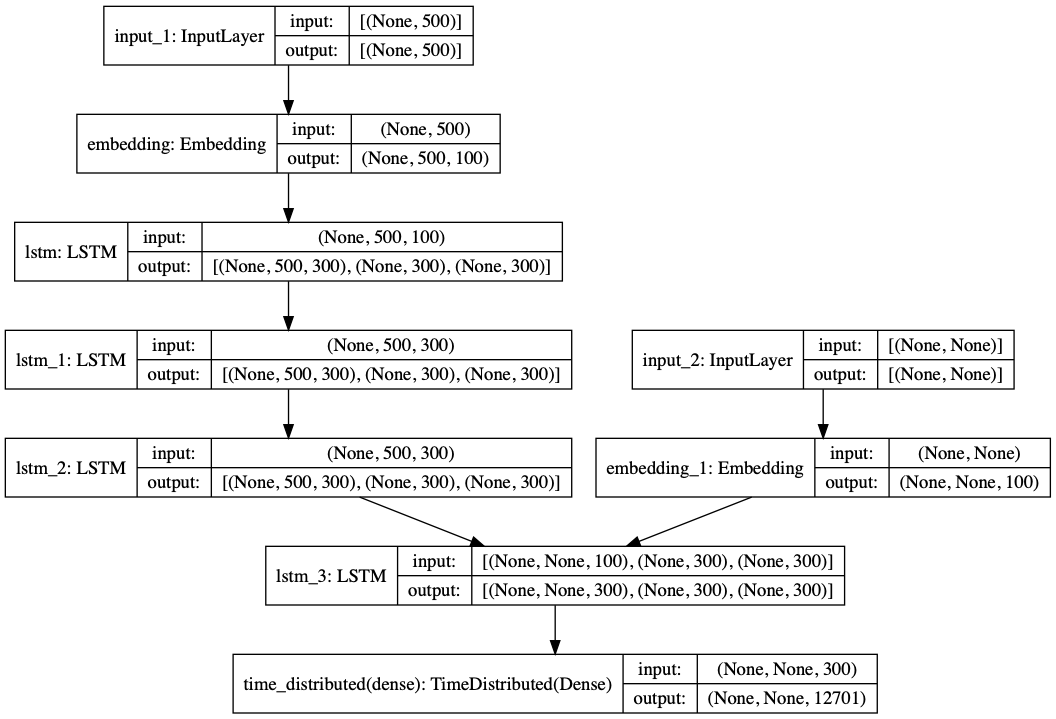

In [34]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Training the Model  
First compile the model and define EarlyStopping to stop training the model once the validation loss metric has stopped decreasing.  

Next, use the model.fit() method to fit the training data where you can define the batch size to be 128. Send the text and summary (excluding the last word in summary) as the input, and a reshaped summary tensor comprising every word (starting from the second word) as the output (which explains the infusion of intelligence into the model to predict a word, given the previous word). Besides, to enable validation during the training phase, send the validation data as well.

In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [36]:
history = model.fit(
    [x_tr, y_tr[:, :-1]],
    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:, 1:],
    epochs=5,
    callbacks=[es],
    batch_size=128,
    validation_data=([x_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]),
    )

Epoch 1/5
68/68 [==============================] - 4717s 70s/step - loss: 5.0748 - val_loss: 4.2324
Epoch 2/5
68/68 [==============================] - 10279s 153s/step - loss: 4.2361 - val_loss: 3.9804
Epoch 3/5
68/68 [==============================] - 1660s 24s/step - loss: 4.0806 - val_loss: 3.9253
Epoch 4/5
68/68 [==============================] - 15794s 235s/step - loss: 4.0062 - val_loss: 3.8439
Epoch 5/5
68/68 [==============================] - 7439s 110s/step - loss: 3.9321 - val_loss: 3.7970


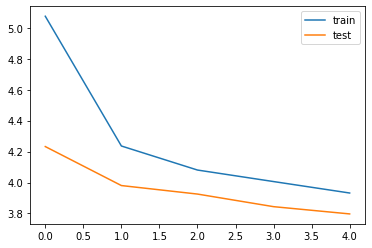

In [37]:
## plot the training and validation loss metrics observed during the training phase.
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### Generating Predictions
To generate summaries from the given pieces of text, first reverse map the indices to the words. 
Map the words to indices from the summaries tokenizer which is to be used to detect the start and end of the sequences.

In [38]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

An encoder inference model accepts text and returns the output generated from the three LSTMs, and hidden and cell states. A decoder inference model accepts the start of the sequence identifier (sostok) and predicts the upcoming word, eventually leading to predicting the whole summary.

In [39]:
# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [40]:
# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2, 
                                                      initial_state=[decoder_state_input_h,
                                                                     decoder_state_input_c]
                                                     )

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [44]:
# To convert sequence to summary
def seq2summary(input_seq):
    new_string = []
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i \
            != target_word_index['eostok']:
            new_string.append(reverse_target_word_index[i])
            
    return  ' '.join(new_string[1:-1])


# To convert sequence to text
def seq2text(input_seq):
    new_string = ''
    for i in input_seq:
        if i != 0:
            new_string = new_string + reverse_source_word_index[i] + ' '

    return new_string


def decode_sequence(input_seq):
    """Generating words until eostok is encountered or the maximum length"""

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = []

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence.append(sampled_token)

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence) >= max_summary_len - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return ' '.join(decoded_sentence[1:-1])

In [46]:
# generate the predictions by sending in the text
for i in range(15, 19):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1, max_text_len)))
    print()

Review: the cbi arrested six officials and private persons in connection with case of alleged corruption in the sports authority of india sai on thursday the arrests were made during searches at sai office in delhi lodhi road bills of lakh were allegedly pending to be cleared by the officials for which demand of 3 was being made 
Original summary: cbi arrests sports of india officials in corruption case
Predicted summary: i to be be be be be

Review: reacting to wrestler photo from the royal shared by the wwe universe twitter account user tweeted when you hit just your toe against in the dark other users reacted to the image with tweets like when you realize tomorrow is monday and when your boss comes into your cube and you re on youtube 
Original summary: when you your user tweets on photo
Predicted summary: i to be be be be be

Review: the ministry of corporate affairs mca is planning to collect know your customer kyc details of companies chartered cost and company secretaries the ex